# 机器学习练习 8 - 异常检测和推荐系统

本章代码涵盖了基于Python的解决方案，用于Coursera机器学习课程的第六个编程练习。 请参考[练习文本](ex8.pdf)了解详细的说明和公式。

代码修改并注释：黄海广，haiguang2000@qq.com

在本练习中，我们将使用高斯模型实现异常检测算法，并将其应用于检测网络上的故障服务器。 我们还将看到如何使用协作过滤构建推荐系统，并将其应用于电影推荐数据集。

## Anomaly detection（异常检测）

我们的第一个任务是使用高斯模型来检测数据集中未标记的示例是否应被视为异常。 我们有一个简单的二维数据集开始，以帮助可视化该算法正在做什么。 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

In [2]:
data = loadmat('data/ex8data1.mat')
X = data['X']
X.shape

(307, 2)

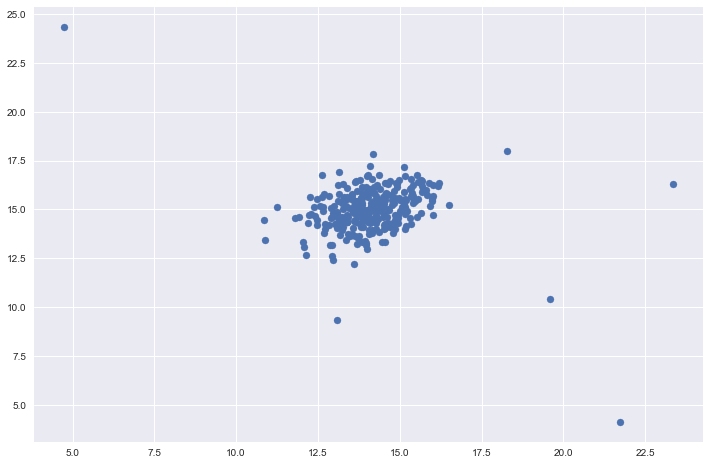

In [3]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
plt.show()

这是一个非常紧密的聚类，几个值远离了聚类。 在这个简单的例子中，这些可以被认为是异常的。 为了弄清楚，我们正在为数据中的每个特征估计高斯分布。 为此，我们将创建一个返回每个要素的均值和方差的函数。

In [4]:
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    
    return mu, sigma

In [5]:
mu, sigma = estimate_gaussian(X)
mu, sigma

(array([ 14.11222578,  14.99771051]), array([ 1.83263141,  1.70974533]))

现在我们有了我们的模型参数，我们需要确定概率阈值，这表明一个样本应该被认为是一个异常。 为此，我们需要使用一组标记的验证数据（其中真实异常样本已被标记），并在给出不同阈值的情况下，对模型的性能进行鉴定。

In [6]:
Xval = data['Xval']
yval = data['yval']

Xval.shape, yval.shape

((307, 2), (307, 1))

我们还需要一种计算数据点属于正态分布的概率的方法。 幸运的是SciPy有这个内置的方法。

In [7]:
from scipy import stats
dist = stats.norm(mu[0], sigma[0])
dist.pdf(15)

0.1935875044615038

我们还可以将数组传递给概率密度函数，并获得数据集中每个点的概率密度。

In [8]:
dist.pdf(X[:,0])[0:50]

array([ 0.183842  ,  0.20221694,  0.21746136,  0.19778763,  0.20858956,
        0.21652359,  0.16991291,  0.15123542,  0.1163989 ,  0.1594734 ,
        0.21716057,  0.21760472,  0.20141857,  0.20157497,  0.21711385,
        0.21758775,  0.21695576,  0.2138258 ,  0.21057069,  0.1173018 ,
        0.20765108,  0.21717452,  0.19510663,  0.21702152,  0.17429399,
        0.15413455,  0.21000109,  0.20223586,  0.21031898,  0.21313426,
        0.16158946,  0.2170794 ,  0.17825767,  0.17414633,  0.1264951 ,
        0.19723662,  0.14538809,  0.21766361,  0.21191386,  0.21729442,
        0.21238912,  0.18799417,  0.21259798,  0.21752767,  0.20616968,
        0.21520366,  0.1280081 ,  0.21768113,  0.21539967,  0.16913173])

我们计算并保存给定上述的高斯模型参数的数据集中每个值的概率密度。

In [9]:
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])

p.shape

(307, 2)

我们还需要为验证集（使用相同的模型参数）执行此操作。 我们将使用与真实标签组合的这些概率来确定将数据点分配为异常的最佳概率阈值。

In [10]:
pval = np.zeros((Xval.shape[0], Xval.shape[1]))
pval[:,0] = stats.norm(mu[0], sigma[0]).pdf(Xval[:,0])
pval[:,1] = stats.norm(mu[1], sigma[1]).pdf(Xval[:,1])

pval.shape

(307, 2)

接下来，我们需要一个函数，找到给定概率密度值和真实标签的最佳阈值。 为了做到这一点，我们将为不同的epsilon值计算F1分数。 F1是真阳性，假阳性和假阴性的数量的函数。 方程式在练习文本中。

In [11]:
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    
    step = (pval.max() - pval.min()) / 1000
    
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float)
        
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = (2 * precision * recall) / (precision + recall)
        
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon
    
    return best_epsilon, best_f1

In [12]:
epsilon, f1 = select_threshold(pval, yval)
epsilon, f1

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


(0.0095667060059568421, 0.7142857142857143)

最后，我们可以将阈值应用于数据集，并可视化结果。

In [13]:
# indexes of the values considered to be outliers
outliers = np.where(p < epsilon)
outliers

(array([300, 301, 301, 303, 303, 304, 306, 306], dtype=int64),
 array([1, 0, 1, 0, 1, 0, 0, 1], dtype=int64))

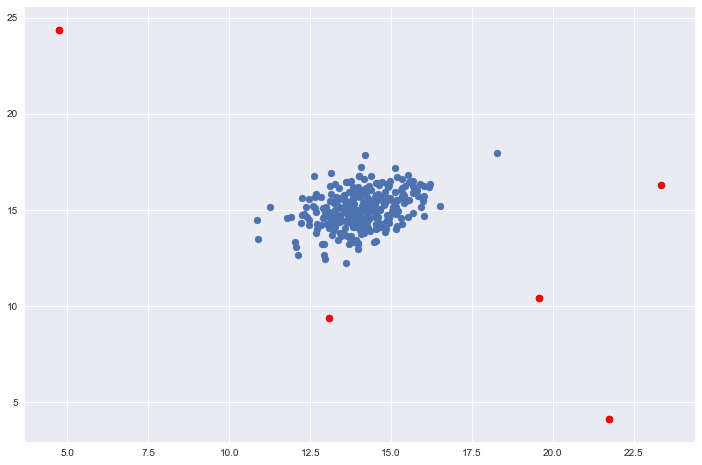

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[:,0], X[:,1])
ax.scatter(X[outliers[0],0], X[outliers[0],1], s=50, color='r', marker='o')
plt.show()

红点是被标记为异常值的点。 这些看起来很合理。 有一些分离（但没有被标记）的右上角也可能是一个异常值，但是相当接近。

## 协同过滤

推荐引擎使用基于项目和用户的相似性度量来检查用户的历史偏好，以便为用户可能感兴趣的新“事物”提供建议。在本练习中，我们将实现一种称为协作过滤的特定推荐系统算法，并将其应用于 电影评分的数据集。

我们首先加载并检查我们将要使用的数据。

In [15]:
data = loadmat('data/ex8_movies.mat')
data

{'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0'}

Y是包含从1到5的等级的（数量的电影x数量的用户）数组.R是包含指示用户是否给电影评分的二进制值的“指示符”数组。 两者应该具有相同的维度。

In [16]:
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

我们可以通过平均排序Y来评估电影的平均评级。

In [17]:
Y[1,np.where(R[1,:]==1)[0]].mean()

3.2061068702290076

我们还可以通过将矩阵渲染成图像来尝试“可视化”数据。 我们不能从这里收集太多，但它确实给我们了解用户和电影的相对密度。

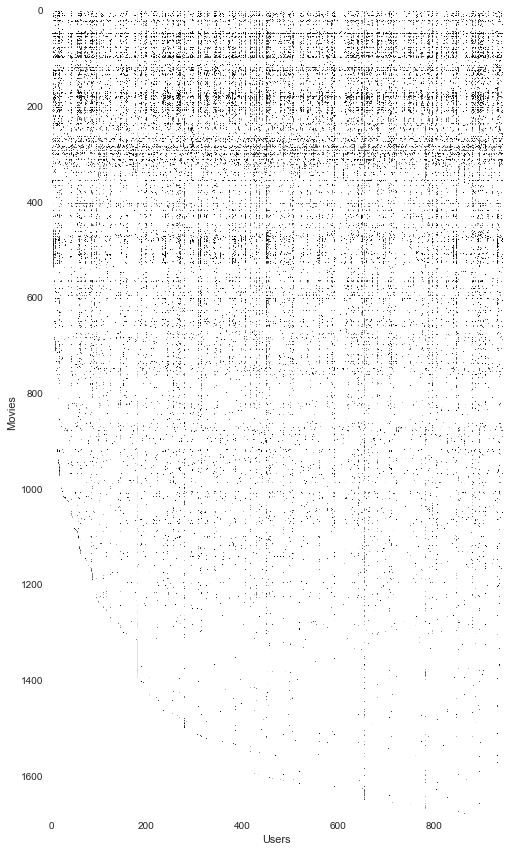

In [18]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()
plt.show()

接下来，我们将实施协同过滤的代价函数。 直觉上，“代价”是指一组电影评级预测偏离真实预测的程度。 代价方程在练习文本中给出。 它基于文本中称为X和Theta的两组参数矩阵。 这些“展开”到“参数”输入中，以便稍后可以使用SciPy的优化包。 请注意，我已经在注释中包含数组/矩阵形状（对于我们在本练习中使用的数据），以帮助说明矩阵交互如何工作。
# cost
<img style="float: left;" src="../img/rcmd_cost.png">

In [19]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    return J

为了测试这一点，我们提供了一组我们可以评估的预训练参数。 为了保持评估时间的少点，我们将只看一小段数据。

In [20]:
params_data = loadmat('data/ex8_movieParams.mat')
X = params_data['X']
Theta = params_data['Theta']
X.shape, Theta.shape

((1682, 10), (943, 10))

In [21]:
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
Theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))

cost(params, Y_sub, R_sub, features)

22.224603725685675

 接下来我们需要实现梯度计算。 就像我们在练习4中使用神经网络实现一样，我们将扩展代价函数来计算梯度。

In [22]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # calculate the gradients
    X_grad = error * Theta
    Theta_grad = error.T * X
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [23]:
J, grad = cost(params, Y_sub, R_sub, features)
J, grad

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

我们的下一步是在代价和梯度计算中添加正则化。 我们将创建一个最终的正则化版本的功能（请注意，此版本包含一个额外的“学习率”参数，在文本中称为“lambda”）。

In [24]:
def cost(params, Y, R, num_features, learning_rate):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # add the cost regularization
    J = J + ((learning_rate / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((learning_rate / 2) * np.sum(np.power(X, 2)))
    
    # calculate the gradients with regularization
    X_grad = (error * Theta) + (learning_rate * X)
    Theta_grad = (error.T * X) + (learning_rate * Theta)
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [25]:
J, grad = cost(params, Y_sub, R_sub, features, 1.5)
J, grad

(31.344056244274221,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

这个结果再次与练习代码的预期输出相匹配，所以看起来正则化是正常的。 在我们训练模型之前，我们有一个最后步骤， 我们的任务是创建自己的电影评分，以便我们可以使用该模型来生成个性化的推荐。 为我们提供一个连接电影索引到其标题的文件。 接着我们将文件加载到字典中。

In [26]:
movie_idx = {}
f = open('data/movie_ids.txt',encoding= 'gbk')
for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])

In [27]:
movie_idx[0]

'Toy Story (1995)'

我们将使用练习中提供的评分。

In [28]:
ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


We can add our own ratings vector to the existing data set to include in the model.
我们可以将自己的评级向量添加到现有数据集中以包含在模型中。

In [29]:
R = data['R']
Y = data['Y']

Y = np.append(Y, ratings, axis=1)
R = np.append(R, ratings != 0, axis=1)

Y.shape, R.shape, ratings.shape

((1682, 944), (1682, 944), (1682, 1))

我们不只是准备训练协同过滤模型。 我们只需要定义一些变量并对评级进行规一化。

In [30]:
movies = Y.shape[0]  # 1682
users = Y.shape[1]  # 944
features = 10
learning_rate = 10.

X = np.random.random(size=(movies, features))
Theta = np.random.random(size=(users, features))
params = np.concatenate((np.ravel(X), np.ravel(Theta)))

X.shape, Theta.shape, params.shape

((1682, 10), (944, 10), (26260,))

In [31]:
Ymean = np.zeros((movies, 1))
Ynorm = np.zeros((movies, users))

for i in range(movies):
    idx = np.where(R[i,:] == 1)[0]
    Ymean[i] = Y[i,idx].mean()
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]

Ynorm.mean()

5.5070364565159845e-19

In [32]:
from scipy.optimize import minimize

fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, features, learning_rate), 
                method='CG', jac=True, options={'maxiter': 100})
fmin

     fun: 38960.83047850314
     jac: array([-0.01842856,  0.00036187,  0.0039912 , ..., -0.00252333,
       -0.00332469,  0.00360307])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 153
     nit: 100
    njev: 153
  status: 1
 success: False
       x: array([-0.19551694,  0.64277558,  0.02459796, ...,  0.14703959,
       -0.1226612 ,  0.01494952])

In [33]:
X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))
Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))

X.shape, Theta.shape

((1682, 10), (944, 10))

我们训练好的参数是X和Theta。 我们可以使用这些来为我们添加的用户创建一些建议。

In [34]:
predictions = X * Theta.T 
my_preds = predictions[:, -1] + Ymean
my_preds.shape

(1682, 1)

In [35]:
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:10]

matrix([[ 5.00000029],
        [ 5.00000016],
        [ 4.99999988],
        [ 4.99999986],
        [ 4.99999972],
        [ 4.99999963],
        [ 4.99999955],
        [ 4.99999923],
        [ 4.99999919],
        [ 4.99999914]])

这给了我们一个排名最高的评级，但我们失去了这些评级的索引。 我们实际上需要使用argsort函数来预测评分对应的电影。

In [36]:
idx = np.argsort(my_preds, axis=0)[::-1]
idx

matrix([[1292],
        [1535],
        [1188],
        ..., 
        [ 783],
        [1333],
        [1358]], dtype=int64)

In [37]:
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movie_idx[j]))

Top 10 movie predictions:
Predicted rating of 5.00000028532343 for movie Star Kid (1997).
Predicted rating of 5.000000164968406 for movie Aiqing wansui (1994).
Predicted rating of 4.999999875154623 for movie Prefontaine (1997).
Predicted rating of 4.999999859773239 for movie They Made Me a Criminal (1939).
Predicted rating of 4.999999720991511 for movie Someone Else's America (1995).
Predicted rating of 4.999999630401129 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating of 4.999999553416016 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicted rating of 4.999999233308761 for movie Saint of Fort Washington, The (1993).
Predicted rating of 4.999999188844037 for movie Great Day in Harlem, A (1994).
Predicted rating of 4.999999143466484 for movie Santa with Muscles (1996).


推荐的电影实际上并不符合练习文本中的内容， 我没有找到原因在哪里。